Cose da fare:


1.   CVAL su rete neurale per bene
2.   AUTOML (cambiando parametri da valutare in xgboost e tutta in NN)
3.   Provare preprocess mettendo tutti i dati di session.
4.   Provare NN solo con dati di train



In [1]:
%tensorflow_version  2.x
! pip install -q keras==2.3.0

     |████████████████████████████████| 378kB 2.7MB/s 


In [2]:
# Per sapere che GPU il signor Google ci regala sta volta

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7432619596674400319, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3337293449475998524
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6372856542016520382
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11150726272
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1910063890615927886
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
! pip install pyGPGO

  Created wheel for pyGPGO: filename=pyGPGO-0.4.0.dev1-cp36-none-any.whl size=19866 sha256=7fe815e8059d6205d29fbc9d7bb1865132a9ff883685971456988432b8cedf10
  Stored in directory: /root/.cache/pip/wheels/d1/27/04/c4fa3bfe194d36e3cd51542132f43415a6813114a5e8301acb
Successfully built pyGPGO


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer, classification_report
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import class_weight



from xgboost.sklearn import XGBClassifier
import xgboost

from keras import models, layers, optimizers, metrics, callbacks


from keras.wrappers.scikit_learn import KerasClassifier


from pyGPGO.surrogates.RandomForest import RandomForest
from pyGPGO.GPGO import GPGO
from pyGPGO.acquisition import Acquisition


import requests
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
plt.rcParams['figure.figsize'] = [10,100] #Dimensioni immagini standard

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Load Data

In [0]:
data = pd.read_csv('/content/drive/My Drive/progetto_aml/dataset/train_prepocessed.csv')

In [8]:
data.head()

,id,age,country_destination,year_first_active,time_lag,month_first_active_sin,month_first_active_cos,day_first_active_sin,day_first_active_cos,weekday_first_active_sin,weekday_first_active_cos,10_count,12_count,15_count,account_count,active_count,agree_terms_check_count,ajax_check_dates_count,ajax_get_referrals_amt_count,ajax_image_upload_count,ajax_lwlb_contact_count,ajax_photo_widget_form_iframe_count,ajax_referral_banner_experiment_type_count,ajax_referral_banner_type_count,ajax_refresh_subtotal_count,ajax_statsd_count,apply_coupon_click_count,apply_coupon_error_count,apply_coupon_error_type_count,apply_reservation_count,ask_question_count,at_checkpoint_count,authenticate_count,authorize_count,available_count,calendar_tab_inner2_count,callback_count,campaigns_count,cancellation_policies_count,cancellation_policy_click_count,...,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,first_device_type_Android Phone,first_device_type_Android Tablet,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_SmartPhone (Other),first_device_type_Windows Desktop,first_device_type_iPad,first_device_type_iPhone,first_browser_-unknown-,first_browser_AOL Explorer,first_browser_Android Browser,first_browser_Chrome,first_browser_Chrome Mobile,first_browser_Chromium,first_browser_Firefox,first_browser_IE,first_browser_Mobile Safari,first_browser_Opera,first_browser_Safari,first_browser_Silk,first_browser_other,most_used_device_-unknown-,most_used_device_Android App Unknown Phone/Tablet,most_used_device_Android Phone,most_used_device_Blackberry,most_used_device_Chromebook,most_used_device_Linux Desktop,most_used_device_Mac Desktop,most_used_device_Opera Phone,most_used_device_Tablet,most_used_device_Windows Desktop,most_used_device_Windows Phone,most_used_device_iPad Tablet,most_used_device_iPhone,most_used_device_iPodtouch
0,gxn3p5htnn,-99.000000,NDF,-4.2844,38.998181,0.866025,5.000000e-01,-0.485302,-0.874347,0.974928,-0.222521,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,820tgsjxq7,0.120931,NDF,-4.2844,61.207505,0.866025,-5.000000e-01,-0.968077,-0.250653,-0.433884,-0.900969,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4ft3gnwmtx,1.659553,US,-4.2844,39.769788,0.500000,-8.660254e-01,0.998717,-0.050649,0.000000,1.000000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,bjjt8pjhuk,0.462847,other,-4.2844,64.009588,-1.000000,-1.836970e-16,-0.201299,0.979530,-0.433884,-0.900969,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,87mebub9p4,0.377368,US,-4.2844,23.430341,-0.500000,8.660254e-01,0.988468,0.151428,0.000000,1.000000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Funzioni utilli

In [0]:
# Funzioni per calcolare ndcg

def dcg_score(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) ))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)



ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

In [0]:
# Top_n accuracy

def top_n_accuracy(y_true, y_pred_prob, n = 5):
    topn = np.argsort(y_pred_prob, axis = 1)[:,-n:]
    acc = np.mean(np.array([1 if y_true[k] in topn[k] else 0 for k in range(len(topn))]))
    return(acc)

In [0]:
# Messaggio su Telegram

def telegram_bot_sendtext(bot_message):
    
    bot_token = '937044171:AAGGDmJcUTkkvDaOwcKrnHUyj9XUND7d52A'
    bot_chatID = '166942243'
    send_text = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + str(bot_message)

    response = requests.get(send_text)

    return response.json()

# Classificatori

## XGboost

In [0]:
data_prova = data.copy()

In [0]:
data_prova.drop(["id"], axis = 1, inplace = True)

In [0]:
X_train, X_test = train_test_split(data_prova, test_size = 0.2, stratify = data_prova["country_destination"], random_state = 42)

In [0]:
y_train = X_train.pop("country_destination")
y_test = X_test.pop("country_destination")

In [0]:
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)

In [0]:
result_exp = pd.read_csv("/content/drive/My Drive/progetto_aml/risultati_AUTOML/risultati_SMBO_exp_XGB.csv")
result_prob = pd.read_csv("/content/drive/My Drive/progetto_aml/risultati_AUTOML/risultati_SMBO_prob_XGB.csv")

In [0]:
hyper_exp = result_exp.sort_values(by="ndcg", ascending=False).head(1).to_dict("r")[0]
hyper_prob = result_prob.sort_values(by="ndcg", ascending=False).head(1).to_dict("r")[0]

In [0]:
xgb = XGBClassifier(max_depth=int(hyper_prob["max_depth"]), learning_rate=hyper_prob["lr"], n_estimators=int(hyper_prob["n_estimator"]),
                    objective='multi:softprob', colsample_bytree=1, 
                    seed=42, n_jobs = -1, tree_method = "gpu_hist", max_delta_step = int(hyper_prob["max_delta_step"]))

In [20]:
a = time.time()
xgb.fit(X_train.values, y_train)
print(time.time()-a)

300.8213174343109


In [21]:
results = xgb.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

AttributeError: ignored

In [0]:
y_pred_prob = xgb.predict_proba(X_test.values)

In [0]:
ndcg_score(encoded_y_test, y_pred_prob, k = 5)

In [0]:
top_n_accuracy(encoded_y_test, y_pred_prob)

0.9587266636996088

### Features Importance

In [0]:
dtrain = xgboost.DMatrix(X_train, label=encoded_y_train)

In [0]:
plt.rcParams['figure.figsize'] = [13,10] #Dimensioni immagini standard

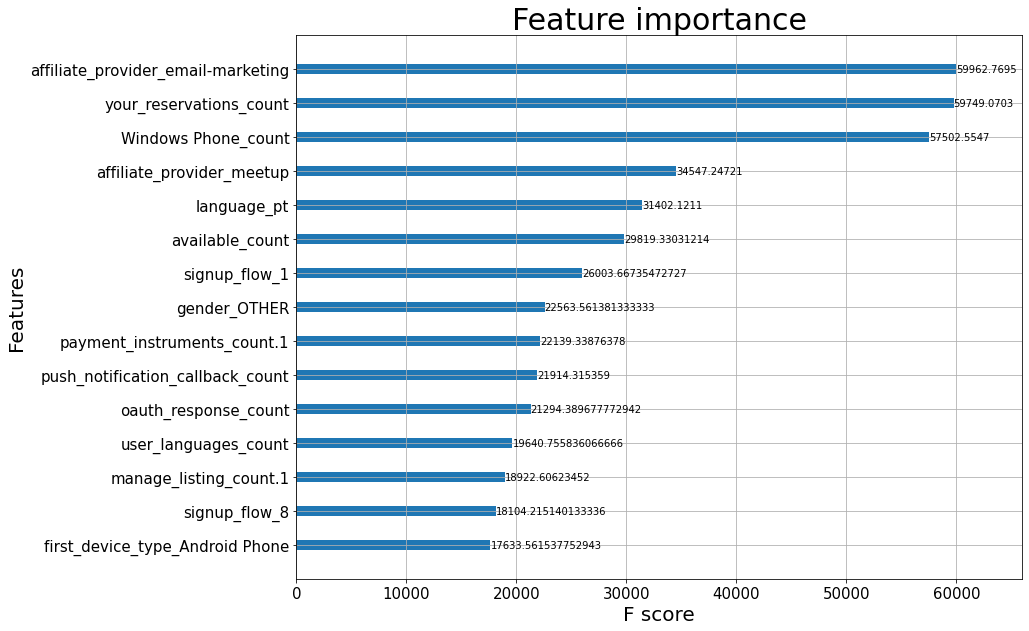

In [27]:
mapper = {'f{0}'.format(i): v for i, v in enumerate(dtrain.feature_names)}
mapped = {mapper[k]: v for k, v in xgb.get_booster().get_score(importance_type="cover").items()}
xgboost.plot_importance(mapped, max_num_features=15, height=0.3)
plt.title("Feature importance", fontsize=30)
plt.xlabel("F score", fontsize=20)
plt.ylabel("Features", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Prova kfold cval

In [0]:
data_prova = data.copy()

In [0]:
data_prova.drop("id", axis = 1, inplace = True)

In [0]:
X_train_cval, X_test = train_test_split(data_prova, test_size = 0.1, stratify = data_prova["country_destination"], random_state = 42)

In [0]:
y_train = X_train_cval.pop("country_destination")
y_test = X_test.pop("country_destination")

In [0]:
Kfold = StratifiedKFold(5, shuffle=True, random_state=42)

In [0]:
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)

In [0]:
xgb = XGBClassifier(max_depth=4, learning_rate=0.5627687919134725, n_estimators=100,
                    objective='multi:softprob', colsample_bytree=1, 
                    seed=42, n_jobs = -1, tree_method = "gpu_hist", max_delta_step = 1)

In [0]:
cval_score = []
for train_index, test_index in Kfold.split(X_train_cval, encoded_y_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = X_train_cval.values[train_index], X_train_cval.values[test_index]
    y_train, y_val = encoded_y_train[train_index], encoded_y_train[test_index]

    xgb.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), (X_val, y_val)], 
        eval_metric = "mlogloss",
        early_stopping_rounds=3)
    
    y_pred_prob = xgb.predict_proba(X_val)
    actual = ndcg_score(y_val, y_pred_prob, k = 5)
    cval_score.append(actual)

TRAIN: [     0      2      4 ... 192099 192100 192101] TEST: [     1      3     10 ... 192102 192103 192104]
[0]	validation_0-mlogloss:1.94397	validation_1-mlogloss:1.94518
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 3 rounds.
[1]	validation_0-mlogloss:1.53885	validation_1-mlogloss:1.54147
[2]	validation_0-mlogloss:1.2916	validation_1-mlogloss:1.29667
[3]	validation_0-mlogloss:1.17503	validation_1-mlogloss:1.18118
[4]	validation_0-mlogloss:1.1142	validation_1-mlogloss:1.1216
[5]	validation_0-mlogloss:1.07938	validation_1-mlogloss:1.08767
[6]	validation_0-mlogloss:1.05824	validation_1-mlogloss:1.06811
[7]	validation_0-mlogloss:1.04552	validation_1-mlogloss:1.05671
[8]	validation_0-mlogloss:1.03696	validation_1-mlogloss:1.04965
[9]	validation_0-mlogloss:1.03029	validation_1-mlogloss:1.04445
[10]	validation_0-mlogloss:1.02557	validation_1-mlogloss:1.04122
[11]	validation_0-mlogl

In [0]:
np.mean(cval_score)

0.8317640824466382

### AUTOML

In [0]:
data_prova = data.copy()

In [0]:
data_prova.drop("id", axis = 1, inplace = True)

In [0]:
X_train_cval, X_test = train_test_split(data_prova, test_size = 0.1, stratify = data_prova["country_destination"], random_state = 42)

In [0]:
y_train = X_train_cval.pop("country_destination")
y_test = X_test.pop("country_destination")

In [0]:
Kfold = StratifiedKFold(5, shuffle=True, random_state=42)

In [0]:
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)

In [0]:
range_lr = [0.01, 1.5]
n_max_depth = [1, 20]
n_estimators = [1, 100] # Ho aggiunto per prova questo e sotto
n_max_delta = [1, 10]
param = {'lr': ('cont', range_lr), 
         'n_max_depth': ('int', n_max_depth),
         'n_estimators' : ('int', n_estimators),
         'n_max_delta' : ('int', n_max_delta)}

rf_model = RandomForest()

f_acq = Acquisition(mode = "ExpectedImprovement")
f_acq1 = Acquisition(mode = "ProbabilityImprovement") 

In [0]:
def compute_ndcg(lr, n_max_depth, n_estimators, n_max_delta):
    xgb = XGBClassifier(max_depth = int(n_max_depth), learning_rate = lr, n_estimators=int(n_estimators),
                        objective = 'multi:softprob', colsample_bytree = 1, 
                        seed=42, n_jobs = -1, tree_method = "gpu_hist", max_delta_step = int(n_max_delta), verbosity=0)
    
    cval_score = []
    i = 1
    for train_index, test_index in Kfold.split(X_train_cval, encoded_y_train):
        
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_val = X_train_cval.values[train_index], X_train_cval.values[test_index]
        y_train, y_val = encoded_y_train[train_index], encoded_y_train[test_index]

        xgb.fit(X_train, y_train, 
            #eval_set = [(X_train, y_train), (X_val, y_val)], 
            #eval_metric = "mlogloss",
            #early_stopping_rounds=3,
            verbose = 0)
        
        y_pred_prob = xgb.predict_proba(X_val)
        actual = ndcg_score(y_val, y_pred_prob, k = 5)
        cval_score.append(actual)
        print("Numero Fold: " + str(i))
        i = i+1

    return np.mean(cval_score)

In [0]:
np.random.seed(42)

SMBO_exp = GPGO(rf_model, f_acq,
                compute_ndcg,
                param, n_jobs = -1)
SMBO_exp.run(init_evals=10,
             max_iter=50)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
Numero Fold: 1
Numero Fold: 2


In [0]:
np.random.seed(42)

SMBO_prob = GPGO(rf_model, f_acq1,
                compute_ndcg,
                param, n_jobs = -1)
SMBO_prob.run(init_evals=5,
             max_iter=20)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
init   	 [ 0.38079472 15.        ]. 	  0.8271076180247443 	 0.8316936650549047
init   	 [0.734674 7.      ]. 	  0.8309489989183575 	 0.8316936650549047
init   	 [ 0.45137443 11.        ]. 	  0.829474039122464 	 0.8316936650549047
init   	 [0.4646564 4.       ]. 	  0.8316936650549047 	 0.8316936650549047
init   	 [0.15143815 3.        ]. 	  0.8314304243971169 	 0.8316936650549047
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
1      	 [0.59498401 4.        ]. 	  0.8314742751573443 	 0.8316936650549047
Numero Fold: 1
Numero Fold: 2
Num

In [0]:
telegram_bot_sendtext("Iperparametri exp : " + str(SMBO_exp.getResult()[0]) + "\n\n" + "NDCG: " + str(SMBO_exp.getResult()[1]))
#telegram_bot_sendtext("Iperparametri prob : " + str(SMBO_prob.getResult()[0]) + "\n\n" + "NDCG: " + str(SMBO_prob.getResult()[1]))

{'ok': True,
 'result': {'chat': {'first_name': 'Federico',
   'id': 166942243,
   'last_name': 'Manenti',
   'type': 'private'},
  'date': 1584106709,
  'from': {'first_name': 'Python',
   'id': 937044171,
   'is_bot': True,
   'username': 'python_notifier_bot'},
  'message_id': 378,
  'text': "Iperparametri: OrderedDict(('lr', 0.5627687919134725), ('n_max_depth', 4.0))\n\nNDCG: 0.8317640824466382"}}

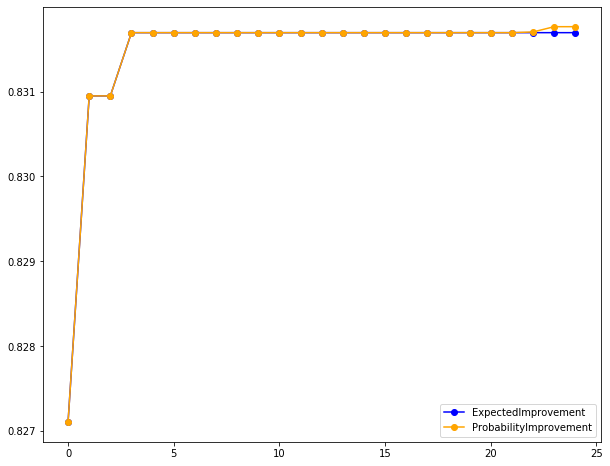

In [0]:
ndcg_exp = np.maximum.accumulate(SMBO_exp.GP.y)
ndcg_prob = np.maximum.accumulate(SMBO_prob.GP.y)

plt.figure(figsize=(10,8))
plt.plot(ndcg_exp,marker='o',color='blue',label="ExpectedImprovement")
plt.plot(ndcg_prob,marker='o',color='orange',label="ProbabilityImprovement")
plt.legend()
plt.show()

In [0]:
def resultDataframe(hyperparams, ndcg):
  result = pd.DataFrame(hyperparams, columns=['lr','max_depth'])
  result['ndcg'] = ndcg
  result['phase']="increment"
  result.loc[0:4,'phase']='initial'
  return result

In [0]:
exp = resultDataframe(SMBO_exp.GP.X, SMBO_exp.GP.y)

In [0]:
exp

,lr,max_depth,ndcg,phase
0,0.380795,15.0,0.827108,initial
1,0.734674,7.0,0.830949,initial
2,0.451374,11.0,0.829474,initial
3,0.464656,4.0,0.831694,initial
4,0.151438,3.0,0.831430,initial
5,0.351621,1.0,0.829252,increment
6,0.587535,17.0,0.823064,increment
7,0.536792,13.0,0.827600,increment
8,0.580525,9.0,0.830009,increment
9,0.827944,5.0,0.831111,increment


In [0]:
SMBO_prob.getResult()[0]

OrderedDict([('lr', 0.5627687919134725), ('n_max_depth', 4.0)])

In [0]:
xgb = XGBClassifier(max_depth=int(SMBO_prob.getResult()[0]["n_max_depth"]), learning_rate=SMBO_prob.getResult()[0]["lr"], n_estimators=100,
                    objective='multi:softprob', colsample_bytree=1, 
                    seed=42, n_jobs = -1, tree_method = "gpu_hist", max_delta_step = 1)

In [0]:
xgb.fit(X_train.values, y_train, 
        eval_set = [(X_train.values, y_train), (X_test.values, y_test)], 
        eval_metric = "mlogloss",
        early_stopping_rounds=3)

[0]	validation_0-mlogloss:1.94407	validation_1-mlogloss:1.94499
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 3 rounds.
[1]	validation_0-mlogloss:1.53887	validation_1-mlogloss:1.54072
[2]	validation_0-mlogloss:1.29271	validation_1-mlogloss:1.29567
[3]	validation_0-mlogloss:1.17601	validation_1-mlogloss:1.17998
[4]	validation_0-mlogloss:1.11507	validation_1-mlogloss:1.11968
[5]	validation_0-mlogloss:1.0805	validation_1-mlogloss:1.08607
[6]	validation_0-mlogloss:1.05973	validation_1-mlogloss:1.06656
[7]	validation_0-mlogloss:1.04696	validation_1-mlogloss:1.05495
[8]	validation_0-mlogloss:1.03787	validation_1-mlogloss:1.04733
[9]	validation_0-mlogloss:1.03177	validation_1-mlogloss:1.04252
[10]	validation_0-mlogloss:1.02694	validation_1-mlogloss:1.03904
[11]	validation_0-mlogloss:1.02349	validation_1-mlogloss:1.03706
[12]	validation_0-mlogloss:1.02022	validation_1-mlogloss:1.0352
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5627687919134725, max_delta_step=1, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

### Prova con XGBoost e dataset bilanciato (Fa schifo)

In [0]:
data_prova = data.copy()

In [0]:
data_prova.pop("id")

0         gxn3p5htnn
1         820tgsjxq7
2         4ft3gnwmtx
3         bjjt8pjhuk
4         87mebub9p4
             ...    
213446    zxodksqpep
213447    mhewnxesx9
213448    6o3arsjbb4
213449    jh95kwisub
213450    nw9fwlyb5f
Name: id, Length: 213451, dtype: object

In [0]:
# Per bilanciare il Dataset

num = data_prova.country_destination.value_counts()[-1]

df_majority = data_prova[data_prova.country_destination=="NDF"]
df_minority = data_prova[data_prova.country_destination=="US"]
df_minority1 = data_prova[data_prova.country_destination=="FR"]
df_minority2 = data_prova[data_prova.country_destination=="other"]
df_minority3 = data_prova[data_prova.country_destination=="ES"]
df_minority4 = data_prova[data_prova.country_destination=="IT"]
df_minority5 = data_prova[data_prova.country_destination=="GB"]
df_minority6 = data_prova[data_prova.country_destination=="CA"]
df_minority7 = data_prova[data_prova.country_destination=="DE"]
df_minority8 = data_prova[data_prova.country_destination=="NL"]
df_minority9 = data_prova[data_prova.country_destination=="AU"]
df_minority10 = data_prova[data_prova.country_destination=="PT"]

In [0]:
train = df_majority[:num].append([df_minority[:num], df_minority1[:num], 
                         df_minority2[:num], df_minority3[:num], df_minority4[:num],
                         df_minority5[:num], df_minority6[:num], df_minority7[:num],
                         df_minority8[:num], df_minority9[:num], df_minority10[:num]], ignore_index = True)

In [0]:
train.country_destination.value_counts()

IT       217
other    217
ES       217
AU       217
NL       217
PT       217
DE       217
NDF      217
US       217
CA       217
FR       217
GB       217
Name: country_destination, dtype: int64

In [0]:
X_train, X_test = train_test_split(train, test_size = 0.2, stratify = train["country_destination"], random_state = 42)

In [0]:
y_train = X_train.pop("country_destination")
y_test = X_test.pop("country_destination")

In [0]:
label_encoder = LabelEncoder()
encoded_y_test = label_encoder.fit_transform(y_test)

In [0]:
xgb = XGBClassifier(max_depth=7, learning_rate=0.18, n_estimators=100,
                    objective='multi:softprob', colsample_bytree=1, seed=42, n_jobs = -1, tree_method='gpu_hist')

In [0]:
xgb.fit(X_train.values, y_train, 
        eval_set = [(X_train.values, y_train), (X_test.values, y_test)], 
        eval_metric = "mlogloss",
        early_stopping_rounds=3)

[0]	validation_0-mlogloss:2.18833	validation_1-mlogloss:2.27581
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 3 rounds.
[1]	validation_0-mlogloss:1.99022	validation_1-mlogloss:2.15738
[2]	validation_0-mlogloss:1.83202	validation_1-mlogloss:2.05723
[3]	validation_0-mlogloss:1.70004	validation_1-mlogloss:1.98729
[4]	validation_0-mlogloss:1.59213	validation_1-mlogloss:1.93114
[5]	validation_0-mlogloss:1.49938	validation_1-mlogloss:1.88335
[6]	validation_0-mlogloss:1.42225	validation_1-mlogloss:1.84768
[7]	validation_0-mlogloss:1.35058	validation_1-mlogloss:1.81487
[8]	validation_0-mlogloss:1.28993	validation_1-mlogloss:1.7915
[9]	validation_0-mlogloss:1.23129	validation_1-mlogloss:1.76932
[10]	validation_0-mlogloss:1.17941	validation_1-mlogloss:1.75482
[11]	validation_0-mlogloss:1.13276	validation_1-mlogloss:1.73934
[12]	validation_0-mlogloss:1.08789	validation_1-mlogloss:1.73198


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.18, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=80, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

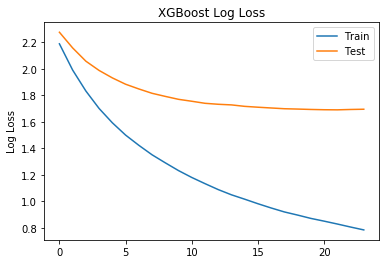

In [0]:
results = xgb.evals_result()
epochs = len(results['validation_1']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

In [0]:
y_pred_prob = xgb.predict_proba(X_test.values)

In [0]:
ndcg_score(encoded_y_test, y_pred_prob, k = 5)

0.6385147094325264

In [0]:
top_n_accuracy(encoded_y_test, y_pred_prob)

0.8790786948176583

### Cross Validation

In [0]:
data_prova = data.copy()

In [0]:
y_train = data_prova['country_destination']
data_prova.drop(['country_destination', 'id'], axis=1, inplace=True)
x_train = data_prova.values

label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)

In [0]:
train_data = xgboost.DMatrix(x_train, encoded_y_train)

In [0]:
def ndcg5_score(preds, dtrain):
    labels = dtrain.get_label()
    top = []

    for i in range(preds.shape[0]):
        top.append(np.argsort(preds[i])[::-1][:5])

    mat = np.reshape(np.repeat(labels,np.shape(top)[1]) == np.array(top).ravel(),np.array(top).shape).astype(int)
    score = np.mean(np.sum(mat/np.log2(np.arange(2, mat.shape[1] + 2)),axis = 1))
    return 'ndcg5', score

In [0]:
param = {
    'max_depth': 7,
    'learning_rate': 0.18,
    'n_estimators': 80,
    'objective': 'multi:softprob',
    'num_class': 12,
    'gamma': 0,
    'min_child_weight': 1, #default
    'max_delta_step': 0, #default
    'subsample': 1, #default
    'colsample_bytree': 1, #default
    'colsample_bylevel': 1, #default
    'reg_alpha': 0, #default 
    'reg_lambda': 1, #default
    'scale_pos_weight': 1, #default 
    'base_score': 0.5, #default 
    'missing': None,
    'n_jobs': -1,
    'seed': 42,
    'tree_method' : 'gpu_hist'
}

num_round = 10
xgboost.cv(param, train_data, num_boost_round=num_round, stratified = True, shuffle = True, metrics = ['mlogloss'], feval = ndcg5_score, maximize=True, nfold = 5, early_stopping_rounds=3)

,train-mlogloss-mean,train-mlogloss-std,train-ndcg5-mean,train-ndcg5-std,test-mlogloss-mean,test-mlogloss-std,test-ndcg5-mean,test-ndcg5-std
0,2.010989,0.000491,0.831544,0.000182,2.013662,0.000564,0.828212,0.000741
1,1.780050,0.000482,0.832402,0.000199,1.784957,0.000938,0.829047,0.000662
2,1.622976,0.000567,0.833170,0.000192,1.629854,0.001211,0.829630,0.000691
3,1.506391,0.000645,0.833700,0.000231,1.515163,0.001291,0.829758,0.000720
4,1.416464,0.000585,0.834131,0.000182,1.426976,0.001481,0.829987,0.000756
5,1.345102,0.000569,0.834630,0.000320,1.357543,0.001599,0.830068,0.000631
6,1.287650,0.000562,0.835001,0.000329,1.301882,0.001776,0.830269,0.000705
7,1.240822,0.000630,0.835472,0.000295,1.256765,0.001802,0.830391,0.000653
8,1.202133,0.000593,0.835831,0.000269,1.219823,0.001911,0.830537,0.000710
9,1.169951,0.000602,0.836247,0.000254,1.189387,0.001960,0.830662,0.000746


## Neural Network

In [0]:
data_prova = data.copy()

In [0]:
data_prova.drop("id", axis = 1, inplace = True)

In [0]:
X_train, X_test = train_test_split(data_prova, test_size = 0.2, stratify = data_prova["country_destination"], random_state = 42)

In [0]:
y_train = X_train.pop("country_destination")
y_test = X_test.pop("country_destination")

In [0]:
label_encoder = LabelEncoder()

encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)

In [0]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(encoded_y_train),
                                                 encoded_y_train)


In [0]:
n_classes = len(np.unique(y_train))
n_features = X_train.shape[1]

In [0]:
result_exp = pd.read_csv("/content/drive/My Drive/progetto_aml/risultati_AUTOML/risultati_SMBO_exp_nn.csv")
result_prob = pd.read_csv("/content/drive/My Drive/progetto_aml/risultati_AUTOML/risultati_SMBO_prob_nn.csv")

In [0]:
hyper_exp = result_exp.sort_values(by="ndcg", ascending=False).head(1).to_dict("r")[0]
hyper_prob = result_prob.sort_values(by="ndcg", ascending=False).head(1).to_dict("r")[0]

In [0]:
hyper_prob

{'lr': 0.00029574255502826964,
 'n_batch_size': 62.0,
 'n_layers': 2.0,
 'n_neuron': 797.0,
 'n_neuron1': 724.0,
 'ndcg': 0.8279987834946505,
 'phase': 'increment'}

In [0]:
model = models.Sequential()

model.add(layers.Dense(797, input_dim =  n_features, activation = "relu"))
model.add(layers.Dense(724, activation = "relu"))
model.add(layers.Dense(724, activation = "relu"))
model.add(layers.Dense(n_classes, activation="softmax"))

In [0]:
es = callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=0, mode='auto')

In [0]:
model.compile(optimizer=optimizers.adam(lr=0.00029574255502826964), 
              loss='sparse_categorical_crossentropy',
              metrics=["acc"]
              )

In [0]:
a = time.time()
history = model.fit(X_train.values, encoded_y_train, 
                    batch_size = 121,
                    epochs = 100,
                    class_weight = class_weights,
                    validation_split = 0.3,
                    callbacks=[es])

print(time.time() - a)

Train on 119531 samples, validate on 51229 samples
Epoch 1/100
119531/119531 [==============================] - 5s 42us/step - loss: 2.0229 - acc: 0.5677 - val_loss: 1.2324 - val_acc: 0.5960
Epoch 2/100
119531/119531 [==============================] - 5s 42us/step - loss: 1.1399 - acc: 0.5995 - val_loss: 1.1263 - val_acc: 0.6205
Epoch 3/100
119531/119531 [==============================] - 5s 41us/step - loss: 1.1058 - acc: 0.6038 - val_loss: 1.1042 - val_acc: 0.6287
Epoch 4/100
119531/119531 [==============================] - 5s 41us/step - loss: 1.0905 - acc: 0.6081 - val_loss: 1.0884 - val_acc: 0.6021
Epoch 5/100
119531/119531 [==============================] - 5s 42us/step - loss: 1.0848 - acc: 0.6091 - val_loss: 1.1130 - val_acc: 0.6075
Epoch 6/100
119531/119531 [==============================] - 5s 42us/step - loss: 1.0807 - acc: 0.6114 - val_loss: 1.0860 - val_acc: 0.6194
Epoch 7/100
119531/119531 [==============================] - 5s 42us/step - loss: 1.0774 - acc: 0.6133 - val_

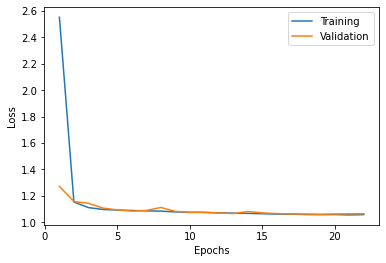

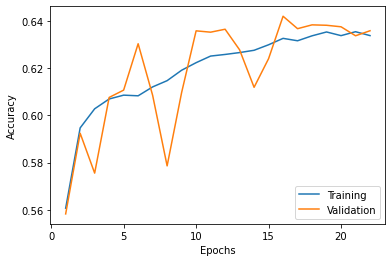

In [0]:
x_plot = list(range(1,history.epoch[-1]+2))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['acc'])
    plt.plot(x_plot, network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'])
    
plot_history(history)

In [0]:
y_pred_prob = model.predict(X_test.values)

In [0]:
ndcg_score(encoded_y_test, y_pred_prob)

0.8264969325686525

### AUTOML

In [0]:
data_prova = data.copy()

In [0]:
data_prova.drop("id", axis = 1, inplace = True)

In [0]:
X_train_cval, X_test = train_test_split(data_prova, test_size = 0.1, stratify = data_prova["country_destination"], random_state = 42)

In [0]:
y_train = X_train_cval.pop("country_destination")
y_test = X_test.pop("country_destination")

In [0]:
Kfold = StratifiedKFold(5, shuffle=True, random_state=42)

In [0]:
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)

In [0]:
n_classes = len(np.unique(y_train))
n_features = X_train_cval.shape[1]

In [0]:
range_lr = [0.01, 1.5]
range_neuron = [16, 1024]
range_batch_size = [1, 128]
range_epochs = [1, 50]

param = {'lr': ('cont', range_lr), 
         'n_neuron': ('int', range_neuron),
         'n_batch_size' : ('int', range_batch_size),
         'n_epochs' : ('int', range_epochs)}

rf_model = RandomForest()

f_acq = Acquisition(mode = "ExpectedImprovement")
f_acq1 = Acquisition(mode = "ProbabilityImprovement") 

In [0]:
def compute_ndcg(lr, n_neuron, n_batch_size, n_epochs):
    model = models.Sequential()

    model.add(layers.Dense(int(n_neuron), input_dim =  n_features, activation = "relu"))
    #model.add(layers.Dense(64, activation = "relu"))
    #model.add(layers.Dense(32, activation = "relu"))
    #model.add(layers.Dense(128, activation = "relu"))
    model.add(layers.Dense(n_classes, activation="softmax"))

    model.compile(optimizer=optimizers.adam(learning_rate = lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=["acc"])
    
    cval_score = []
    i = 1
    for train_index, test_index in Kfold.split(X_train_cval, encoded_y_train):
        
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_val = X_train_cval.values[train_index], X_train_cval.values[test_index]
        y_train, y_val = encoded_y_train[train_index], encoded_y_train[test_index]

        class_weights = class_weight.compute_class_weight('balanced', 
                                                          np.unique(y_train), y_train)
        
        model.fit(X_train, y_train, 
                    batch_size = int(n_batch_size),
                    epochs = int(n_epochs),
                    class_weight = class_weights)
        
        y_pred_prob = model.predict(X_val)
        actual = ndcg_score(y_val, y_pred_prob, k = 5)
        cval_score.append(actual)
        print("Numero Fold: " + str(i))
        i = i+1

    return np.mean(cval_score)

In [0]:
def create_model(n_neuron1, n_neuron2, n_layers):
    model = models.Sequential()

    model.add(layers.Dense(int(n_neuron1), input_dim = n_features, activation = "relu"))
    model.add(layers.Dropout(0.2))

    for i in range(int(n_layers)) :
        model.add(layers.Dense(int(n_neuron2), activation="relu"))
        model.add(layers.Dropout(0.2))


    model.add(layers.Dense(n_classes, activation="softmax"))
    
    return model

In [0]:
# Prova senza epoche

es = callbacks.EarlyStopping(monitor='loss',
                              min_delta=0,
                              patience=3,
                              verbose=0, mode='auto')

range_lr = [0.0001, 0.1]
range_neuron1 = [8, 1024]
range_neuron2 = [8, 1024]
range_layers = [0, 2]
range_batch_size = [1, 128]

param = {'lr': ('cont', range_lr), 
         'n_neuron1': ('int', range_neuron1),
         'n_batch_size' : ('int', range_batch_size),
         'n_neuron2' : ('int', range_neuron2),
         'n_layers' : ('int', range_layers)}

rf_model = RandomForest()

f_acq = Acquisition(mode = "ExpectedImprovement")
f_acq1 = Acquisition(mode = "ProbabilityImprovement") 

def compute_ndcg(lr, n_neuron1, n_neuron2, n_layers, n_batch_size):

    model = create_model(n_neuron1, n_neuron2, n_layers)

    model.compile(optimizer=optimizers.adam(learning_rate = lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=["acc"])
    
    cval_score = []
    i = 1
    for train_index, test_index in Kfold.split(X_train_cval, encoded_y_train):
        
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_val = X_train_cval.values[train_index], X_train_cval.values[test_index]
        y_train, y_val = encoded_y_train[train_index], encoded_y_train[test_index]

        class_weights = class_weight.compute_class_weight('balanced', 
                                                          np.unique(y_train), y_train)
        
        model.fit(X_train, y_train, 
                  batch_size = int(n_batch_size),
                  epochs = 100,
                  class_weight = class_weights,
                  callbacks = [es],
                  verbose = 0)
        
        y_pred_prob = model.predict(X_val)
        actual = ndcg_score(y_val, y_pred_prob, k = 5)
        cval_score.append(actual)
        print("Numero Fold: " + str(i))
        i = i+1

    return np.mean(cval_score)

In [0]:
np.random.seed(42)

SMBO_exp_nn = GPGO(rf_model, f_acq,
                compute_ndcg,
                param, n_jobs = -1)
SMBO_exp_nn.run(init_evals=10,
             max_iter=70)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
init   	 [3.75165579e-02 8.68000000e+02 1.50000000e+01 1.14000000e+02
 1.00000000e+00]. 	  0.8058849590564439 	 0.8067688132885269
init   	 [3.4508365e-02 6.9700000e+02 1.0000000e+00 2.0300000

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
1      	 [2.65507329e-02 7.99000000e+02 6.00000000e+00 4.81000000e+02
 1.00000000e+00]. 	  0.8065509236695556 	 0.8067688132885269


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Numero Fold: 1


In [0]:
telegram_bot_sendtext("Iperparametri exp nn: " + str(SMBO_exp_nn.getResult()[0]) + "\n\n" + "NDCG: " + str(SMBO_exp_nn.getResult()[1]))
#telegram_bot_sendtext("Iperparametri prob : " + str(SMBO_prob.getResult()[0]) + "\n\n" + "NDCG: " + str(SMBO_prob.getResult()[1]))

### Cross Validation

In [0]:
def dnn_model():
    model = models.Sequential()

    model.add(layers.Dense(128, input_dim =  n_features, activation = "relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation = "relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(n_classes, activation="softmax"))

    # compile model
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer="adam", 
                  metrics=["acc"]
                  )
    return model

In [0]:
es = callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=0, mode='auto')

In [0]:
model = KerasClassifier(build_fn=dnn_model,
                        epochs = 10,
                        validation_split = 0.3,
                        callbacks = [es])

In [0]:
history = model.fit(X_train.values, encoded_y_train, 
                    class_weight = class_weights,
                    epochs = 50)

Train on 119531 samples, validate on 51229 samples
Epoch 1/50
119531/119531 [==============================] - 28s 236us/step - loss: 1.2029 - acc: 0.5756 - val_loss: 1.1938 - val_acc: 0.5947
Epoch 2/50
119531/119531 [==============================] - 27s 228us/step - loss: 1.0969 - acc: 0.6042 - val_loss: 1.1946 - val_acc: 0.5905
Epoch 3/50
119531/119531 [==============================] - 28s 233us/step - loss: 1.1019 - acc: 0.6092 - val_loss: 1.2435 - val_acc: 0.5869
Epoch 4/50
119531/119531 [==============================] - 27s 230us/step - loss: 1.1423 - acc: 0.5946 - val_loss: 1.1696 - val_acc: 0.5824
Epoch 5/50
119531/119531 [==============================] - 27s 229us/step - loss: 1.1638 - acc: 0.5839 - val_loss: 1.1737 - val_acc: 0.5824
Epoch 6/50
119531/119531 [==============================] - 28s 234us/step - loss: 1.1633 - acc: 0.5839 - val_loss: 1.1679 - val_acc: 0.5824
Epoch 7/50
119531/119531 [==============================] - 28s 235us/step - loss: 1.1633 - acc: 0.5839

In [0]:
y_pred_proba = model.predict_proba(X_test.values)

In [0]:
ndcg_score(encoded_y_test, y_pred_proba)

0.8067661822895518

In [0]:
#Cross validation

cval_scores = cross_val_score(model, X_train.values, encoded_y_train, cv=5, scoring=ndcg_scorer)


Train on 95625 samples, validate on 40983 samples
Epoch 1/10
95625/95625 [==============================] - 12s 121us/step - loss: 3.9621 - acc: 0.5518 - val_loss: 1.1532 - val_acc: 0.6061
Epoch 2/10
95625/95625 [==============================] - 11s 119us/step - loss: 1.1133 - acc: 0.5977 - val_loss: 1.1662 - val_acc: 0.6231
Epoch 3/10
95625/95625 [==============================] - 11s 119us/step - loss: 1.1012 - acc: 0.6061 - val_loss: 1.0888 - val_acc: 0.6371
Epoch 4/10
95625/95625 [==============================] - 11s 119us/step - loss: 1.1010 - acc: 0.6077 - val_loss: 1.1098 - val_acc: 0.6215
Epoch 5/10
95625/95625 [==============================] - 12s 122us/step - loss: 1.0965 - acc: 0.6110 - val_loss: 1.1068 - val_acc: 0.6054
Epoch 6/10
95625/95625 [==============================] - 12s 128us/step - loss: 1.0928 - acc: 0.6128 - val_loss: 1.1495 - val_acc: 0.6009
Epoch 7/10
95625/95625 [==============================] - 11s 120us/step - loss: 1.0915 - acc: 0.6156 - val_loss: 1.

In [0]:
np.mean(cval_scores)

0.8193382369637281

## NN one_vs_all

In [0]:
data_prova = data[:10000].copy()

In [0]:
data_prova.drop("id", axis = 1, inplace = True)

In [0]:
X_train, X_test = train_test_split(data_prova, test_size = 0.2, stratify = data_prova["country_destination"], random_state = 42)

In [0]:
y_train = X_train.pop("country_destination")
y_test = X_test.pop("country_destination")

In [0]:
label_encoder = LabelEncoder()

encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)

In [0]:
n_classes = len(np.unique(y_train))
n_features = X_train.shape[1]

In [0]:
def dnn_model(n_comps):
    model = models.Sequential()
    model.add(layers.Dense(n_comps, input_dim=n_comps, activation='relu'))
    #model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation="relu"))
    #model.add(layers.Dropout(0.3))
    model.add(layers.Dense(2, activation='softmax'))

    # compile model
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer="adam", 
                  metrics=[metrics.accuracy])
    return model


In [0]:
model = KerasClassifier(build_fn=dnn_model, n_comps=n_features, 
                        batch_size = 16,
                        epochs = 1,
                        validation_split = 0.3)
clf = OneVsRestClassifier(model)

In [0]:
clf.fit(X_train.values, encoded_y_train)

Train on 5600 samples, validate on 2400 samples
Epoch 1/1
5600/5600 [==============================] - 1s 227us/step - loss: 2.6227 - accuracy: 0.4723 - val_loss: 0.5891 - val_accuracy: 0.5000
Train on 5600 samples, validate on 2400 samples
Epoch 1/1
5600/5600 [==============================] - 1s 225us/step - loss: 4.9484 - accuracy: 0.3879 - val_loss: 0.4722 - val_accuracy: 0.0067
Train on 5600 samples, validate on 2400 samples
Epoch 1/1
5600/5600 [==============================] - 1s 228us/step - loss: 3.1217 - accuracy: 0.4312 - val_loss: 2.5620 - val_accuracy: 0.0000e+00
Train on 5600 samples, validate on 2400 samples
Epoch 1/1
5600/5600 [==============================] - 1s 223us/step - loss: 2.4660 - accuracy: 0.1621 - val_loss: 1.0093 - val_accuracy: 0.0081
Train on 5600 samples, validate on 2400 samples
Epoch 1/1
5488/5600 [============================>.] - ETA: 0s - loss: 5.9169 - accuracy: 0.2281

KeyboardInterrupt: ignored

In [0]:
y_pred_prob = clf.predict_proba(X_test.values)

In [0]:
ndcg_score(encoded_y_test, y_pred_prob, k = 5)

0.80564852692792

In [0]:
top_n_accuracy(encoded_y_test, y_pred_prob)

0.9569230048487972

In [0]:
#Cross validation

cval_scores = cross_val_score(clf, X_train.values, encoded_y_train, cv=5, scoring=ndcg_scorer)
test_score = clf.score(X=X_test.values, y=encoded_y_test)

Train on 4480 samples, validate on 1920 samples
Epoch 1/1
4480/4480 [==============================] - 1s 220us/step - loss: 2.0519 - accuracy: 0.4775 - val_loss: 2.4105 - val_accuracy: 0.5000
Train on 4480 samples, validate on 1920 samples
Epoch 1/1
4480/4480 [==============================] - 1s 219us/step - loss: 3.7754 - accuracy: 0.3657 - val_loss: 1.2679 - val_accuracy: 0.5000
Train on 4480 samples, validate on 1920 samples
Epoch 1/1
4480/4480 [==============================] - 1s 221us/step - loss: 3.6983 - accuracy: 0.4641 - val_loss: 0.8951 - val_accuracy: 0.5000
Train on 4480 samples, validate on 1920 samples
Epoch 1/1
4480/4480 [==============================] - 1s 220us/step - loss: 6.9676 - accuracy: 0.4112 - val_loss: 3.0874 - val_accuracy: 0.5000
Train on 4480 samples, validate on 1920 samples
Epoch 1/1
4480/4480 [==============================] - 1s 227us/step - loss: 5.4036 - accuracy: 0.1895 - val_loss: 3.5040 - val_accuracy: 0.0227
Train on 4480 samples, validate on 

NotFittedError: ignored

In [0]:
cval_scores

array([0.66506884, 0.73680992, 0.66231506, 0.75196868, 0.66950634])

## SVM (Lento come la morte)

In [0]:
### SVM

In [0]:
from sklearn.svm import SVC

clf3 = SVC(kernel='rbf', class_weight='balanced',
           decision_function_shape='ovo', probability=True, cache_size = 2000)


In [0]:
clf3 = clf3.fit(X_train, y_train)

In [0]:
y_pred_prob = clf3.predict_proba(X_test.values)

In [0]:
ndcg_score(encoded_y_test, y_pred_prob, k = 5)

In [0]:
### FINE SVM

## Feature selection (inutile)

In [0]:
# Feature Importance with Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier


In [0]:
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X_test.values, encoded_y_test)
print(model.feature_importances_)

[9.31496752e-02 2.82285407e-02 9.42596604e-02 4.86761625e-02
 4.88587147e-02 6.60972153e-02 6.31381480e-02 4.63381233e-02
 3.89492431e-02 1.01701358e-04 1.87652546e-04 5.94836540e-05
 5.08783395e-04 1.60105394e-03 5.04225017e-04 1.08381911e-03
 1.00154541e-03 6.15569415e-04 8.30400607e-04 4.82617886e-04
 6.55298688e-04 6.49496536e-04 2.24029027e-03 2.26115290e-04
 2.26139062e-05 6.34729054e-05 2.74210053e-05 3.90465603e-04
 1.55385270e-03 9.52308687e-04 1.69308505e-03 3.36924725e-05
 1.80460438e-04 1.19594453e-03 5.22957266e-04 9.33381730e-04
 1.52591025e-03 9.00613095e-05 4.52781589e-05 3.22394274e-04
 5.40192381e-04 1.58489516e-04 5.47949818e-04 4.71394051e-04
 1.77777415e-03 3.55056864e-04 1.35218470e-04 7.81312645e-05
 5.36548048e-05 2.44724237e-03 2.31012840e-04 0.00000000e+00
 1.78207919e-03 2.16538358e-04 4.99893161e-04 1.83066688e-04
 1.15990643e-03 9.11426291e-04 1.05916473e-04 3.48364185e-04
 5.19814743e-04 2.48426141e-04 1.82602680e-04 9.32074547e-05
 3.06926283e-04 1.837943

In [0]:
X_train.columns[np.array(model.feature_importances_).argsort()[::-1][:100]]

Index(['time_lag', 'age', 'day_first_active_sin', 'day_first_active_cos',
       'month_first_active_cos', 'month_first_active_sin',
       'weekday_first_active_sin', 'weekday_first_active_cos',
       'year_first_active', 'gender_-unknown-', 'first_browser_Chrome',
       'signup_method_facebook', 'first_browser_Firefox', 'gender_MALE',
       'gender_FEMALE', 'first_affiliate_tracked_untracked',
       'first_affiliate_tracked_linked', 'signup_method_basic',
       'first_device_type_Windows Desktop', 'first_device_type_Mac Desktop',
       'first_browser_Safari', 'first_affiliate_tracked_omg',
       'pending_count.1', 'signup_flow_0', 'first_browser_IE', 'signup_flow_3',
       'affiliate_provider_google', 'affiliate_channel_sem-brand',
       'secs_elapsed_min', 'affiliate_channel_sem-non-brand',
       'secs_elapsed_max', 'affiliate_channel_direct', 'secs_elapsed_median',
       'secs_elapsed_std', 'affiliate_provider_direct', 'secs_elapsed_sum',
       'secs_elapsed_mean', 'fir

In [0]:
np.array(model.feature_importances_).argsort()[::-1][:100]

array([  2,   0,   5,   6,   4,   3,   7,   8,   1, 287, 378, 292, 381,
       289, 288, 361, 355, 291, 372, 369, 385, 358, 221, 294, 382, 297,
       348, 339, 278, 340, 279, 336, 280, 281, 344, 276, 277, 383, 286,
       165, 284, 315, 296, 341, 282, 283, 285, 160, 166, 360, 188, 129,
       373, 161, 374, 375, 157, 167,  96, 219,  70, 256, 208, 162, 217,
        49, 351, 121, 258, 152,  22, 370, 364, 190, 337, 268, 125,  98,
       237, 182, 335,  81, 194, 225, 184, 202, 365,  65, 271, 241,  52,
        44, 135, 183,  30, 247, 155, 150,  13,  28])